<a href="https://colab.research.google.com/github/murarosilva/Profitos/blob/main/Amazon_TRL_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TRL paper classification**

The objective of this code is to classify academic output (papers) related to Amazonian plant species according to their Technology Readness Level. This research is part of PROFitos project, funded by FAPESP (https://www.ige.unicamp.br/profitos/). This code was written by [Alysson Mazoni](https://github.com/alyssonmazoni) and [Vinicius Muraro](https://github.com/murarosilva)

Import all necessary libraries and authenticate user on Google Colab

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import STOPWORDS
import gensim
from gensim import models
import pprint
from nltk.stem import WordNetLemmatizer
from gensim.matutils import hellinger
from gensim.matutils import jaccard
from gensim.matutils import kullback_leibler
from gensim.matutils import jensen_shannon
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/drive/')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Mounted at /content/drive/


Upload database

In [ ]:
folder = '/content/drive/My Drive/[2] Unicamp/[1] Politica Cientifica e Tecnologica/[2] My Papers & Projects/[1] PROFITOS/Amazon_TRL_Classification/'
works = pd.read_csv(folder+'scopus_2002-2022.csv', error_bad_lines=False)
works = works.fillna('')

<ipython-input-2-927d74af938f>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  works = pd.read_csv(folder+'scopus_2002-2022.csv', error_bad_lines=False)
Skipping line 857: expected 54 fields, saw 57



Upload manual classification and merge with main database (works)

In [ ]:
class_works = pd.read_excel(folder+'Amazon_Geral_TRL_draft_v4.xlsx',sheet_name='Papers para Classificar',dtype=str)
works_merged = pd.merge(works, class_works[[' DOI','Class. Manual']], left_on='DOI', right_on=' DOI', how='left')

Using Title, Abstract and Keywords for text classification

In [ ]:
works_merged['nlp_text'] = works_merged['Title']+' '+works_merged['Abstract']+' '+works_merged['Author Keywords']

Upload TRL keywords list

In [ ]:
keywords = pd.read_excel(folder+'New_Amazon_Geral_Keywords.xlsx')
keys_TRL = []
for i in range(5):
  keys_TRL += [' '.join(list(keywords.loc[keywords.iloc[:,i+4]==1,'Keywords (Cleaned)']))]

Add classified papers to keyword lists corresponding to each TRL

In [ ]:
cats = ['1','2','3','4', '5']
c = cats[0]
TRL_train = keys_TRL

for i,c in enumerate(cats):
  ii = works_merged['Class. Manual']==c

  TRL_train[i] +=' '.join(list(works_merged.loc[ii,'nlp_text']))

Uploading stopwords and preprocessing text data

In [ ]:
stopwords = set(STOPWORDS)
my_stopwords = {'approach','paper','article','model','viewpoint','conclusion',
                'discussion','method','introduction','section','framework',
                'based','result','characteristic','implication','analysis',
                'evidence','description','associated',
                'observation','describe'} #pensar em colocar mais stopwords
my_stopwords = set.union(stopwords,my_stopwords)
my_stopwords = frozenset(my_stopwords)

Lemmatization of NLP texts

In [ ]:
nlp_texts_lem = []
lem = WordNetLemmatizer()
for text in list(works_merged['nlp_text']):
    txt = gensim.utils.simple_preprocess(text)
    txt = [word for word in txt if word not in my_stopwords]
    for i,t in enumerate(txt):
        txt[i] = lem.lemmatize(t)
    nlp_texts_lem += [txt]

Creating a bag of words of NLP lemmatized texts

In [ ]:
dictionary = gensim.corpora.Dictionary(nlp_texts_lem)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in nlp_texts_lem]

Creating and training a TF-IDF model based on the bag of words

In [ ]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

Training LDA model

In [ ]:
n_topics = 20
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=n_topics, id2word=dictionary, passes=10, workers=4)
topics_text = []
for idx, topic in lda_model_tfidf.print_topics(-1):
    topics_text += ['Topic: {} \nWords: {}'.format(idx, topic)]
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.035*"antimicrobial" + 0.031*"aureus" + 0.025*"staphylococcus" + 0.025*"atcc" + 0.022*"candida" + 0.019*"aeruginosa" + 0.018*"mic" + 0.017*"albicans" + 0.016*"antibacterial" + 0.016*"pseudomonas"
Topic: 1 Word: 0.040*"antimalarial" + 0.026*"falciparum" + 0.024*"plasmodium" + 0.017*"malaria" + 0.010*"snakebite" + 0.009*"germination" + 0.008*"french" + 0.006*"do" + 0.006*"aspidosperma" + 0.006*"principle"
Topic: 2 Word: 0.043*"ayahuasca" + 0.008*"dmt" + 0.007*"olacoides" + 0.006*"addiction" + 0.006*"ptychopetalum" + 0.006*"religious" + 0.006*"self" + 0.005*"caapi" + 0.005*"disorder" + 0.005*"depression"
Topic: 3 Word: 0.034*"larva" + 0.031*"aegypti" + 0.021*"larvicidal" + 0.020*"aedes" + 0.017*"mosquito" + 0.016*"insecticide" + 0.013*"marine" + 0.012*"vector" + 0.009*"insect" + 0.006*"carapa"
Topic: 4 Word: 0.017*"açaí" + 0.013*"oleracea" + 0.012*"euterpe" + 0.010*"açai" + 0.008*"negro" + 0.008*"microscopy" + 0.007*"surface" + 0.007*"land" + 0.007*"streptococcus" + 0.006*

Fit all texts bag of words into trained LDA model

In [ ]:
bow_nlp_texts = []
model_nlp_texts = []
for j in nlp_texts_lem:
  mt = lda_model_tfidf.id2word.doc2bow(j)
  bow_nlp_texts += [mt]
  model_nlp_texts += [lda_model_tfidf[mt]]

Preprocessing TRL trained database

In [ ]:
trl_texts_lem = []
for text in TRL_train:
    txt = gensim.utils.simple_preprocess(text)
    txt = [word for word in txt if word not in my_stopwords]
    for i,t in enumerate(txt):
        txt[i] = lem.lemmatize(t)
    trl_texts_lem += [txt]

Preprocessing TRL keywords (tentative)

In [ ]:
trl_key_lem = []
for text in keys_TRL:
  txt = gensim.utils.simple_preprocess(text)
  txt = [word for word in txt if word not in my_stopwords]
  for i,t in enumerate(txt):
    txt[i] = lem.lemmatize(t)
  trl_key_lem += [txt]

Fit TRL trained database bag of words into the trained LDA model

In [ ]:
bow_trl_texts = []
model_trl_texts = []
for k in trl_texts_lem:
  mk = lda_model_tfidf.id2word.doc2bow(k)
  bow_trl_texts += [mk]
  model_trl_texts += [lda_model_tfidf[mk]]

Fit TRL keywords database bag of words into the trained LDA model (tentative)

In [ ]:
bow_key_texts = []
model_key_texts = []
for k in trl_key_lem:
  mk = lda_model_tfidf.id2word.doc2bow(k)
  bow_key_texts += [mk]
  model_key_texts += [lda_model_tfidf[mk]]

Checking different distant measures

In [ ]:
model_trl = model_trl_texts #or model_key_texts if we want to test without the classified papers (just keywords for each TRL)
bow_trl = bow_trl_texts #or bow_key_texts if we want to test without the classified papers (just keywords for each TRL)

n = len(model_nlp_texts)
m = len(model_trl)
Dh = np.zeros((n,m))
for i,a in enumerate(model_nlp_texts):
  for j,b in enumerate(model_trl):
    Dh[i,j] = hellinger(a,b)

n = len(model_nlp_texts)
m = len(model_trl)
Dkl = np.zeros((n,m))
for i,a in enumerate(model_nlp_texts):
  for j,b in enumerate(model_trl):
    Dkl[i,j] = kullback_leibler(a,b,num_features=n_topics)

n = len(model_nlp_texts)
m = len(model_trl)
Djl = np.zeros((n,m))
for i,a in enumerate(model_nlp_texts):
  for j,b in enumerate(model_trl):
    Djl[i,j] = jensen_shannon(a,b,num_features=n_topics)

n = len(bow_nlp_texts)
m = len(bow_trl)
Dj = np.zeros((n,m))
for i,a in enumerate(bow_nlp_texts):
  for j,b in enumerate(bow_trl):
    Dj[i,j] = jaccard(a,b)


In [ ]:
Class_TRL = np.argmin(Dh,axis=1)
d_texts = np.min(Dh,axis=1)
works_merged['TR_hellinger'] = Class_TRL+1

Class_TRL = np.argmin(Dkl,axis=1)
d_texts = np.min(Dkl,axis=1)
works_merged['TR_kullback_leibler'] = Class_TRL+1

Class_TRL = np.argmin(Dkl,axis=1)
d_texts = np.min(Dkl,axis=1)
works_merged['TR_jensen_shannon'] = Class_TRL+1

Class_TRL = np.argmin(Dj,axis=1)
d_texts = np.min(Dj,axis=1)
works_merged['TR_jaccard'] = Class_TRL+1

#Trying to collect the second best classification - NOT IN USE NOW
#TR_texts_second = np.argsort(D,axis=1)[:,1]
#d2_texts = np.sort(D,axis=1)[:,2]
#works_merged['TR_second'] = TR_texts_second+1

In [ ]:
works_merged.loc[works_merged['Class. Manual'].notnull()].iloc[:,[2,55,57,58,59,60]]

,Title,Class. Manual,TR_hellinger,TR_kullback_leibler,TR_jensen_shannon,TR_jaccard
164,Anti-inflammatory potential of the oleoresin f...,4,4,4,4,4
165,Secondary metabolites found among the species ...,3,2,1,1,3
166,Croton lechleri extracts as green corrosion in...,2,2,2,2,2
167,Kaniuwatewara (when we get sick): understandin...,5,1,1,1,5
168,In vitro propagation of the Amazonian medicina...,1,5,1,1,5
...,...,...,...,...,...,...
873,"Medicinal plants at Rio Jauaperi, Brazilian Am...",1,1,1,1,5
893,Ethnobotany of babassu palm (Attalea speciosa ...,1,1,1,1,1
1011,The domestication of annatto (Bixa orellana) f...,1,1,1,1,1
1044,Conservation and use,1,1,1,1,2


In [ ]:
works_merged.to_excel(folder+'TRL_classification.xlsx')

In [ ]:
T = works_merged
T = T[['Class. Manual','TR_hellinger','TR_jaccard','TR_kullback_leibler','TR_jensen_shannon']]
x = T.index.values
y = T['Class. Manual'].replace('','0').fillna('0').astype(int).values
z = T['TR_hellinger'].fillna('0').astype(int).values
w = T['TR_jaccard'].fillna('0').astype(int).values
k = T['TR_kullback_leibler'].fillna('0').astype(int).values
j = T['TR_jensen_shannon'].fillna('0').astype(int).values

In [ ]:
eh = y[y>0]-z[y>0]
ej = y[y>0]-w[y>0]
ekl = y[y>0]-k[y>0]
ejs = y[y>0]-j[y>0]
print('Hellinger:',np.sum(eh!=0)/len(eh),
      'Jaccard:',np.sum(ej!=0)/len(ej),
      'Kullback-Leibler:',np.sum(ekl!=0)/len(ekl),
      'Jensen-Shannon:',np.sum(ejs!=0)/len(ejs))

Hellinger: 0.2336448598130841 Jaccard: 0.22429906542056074 Kullback-Leibler: 0.3644859813084112 Jensen-Shannon: 0.3644859813084112


Text(0.5, 1.0, 'Jaccard distance')

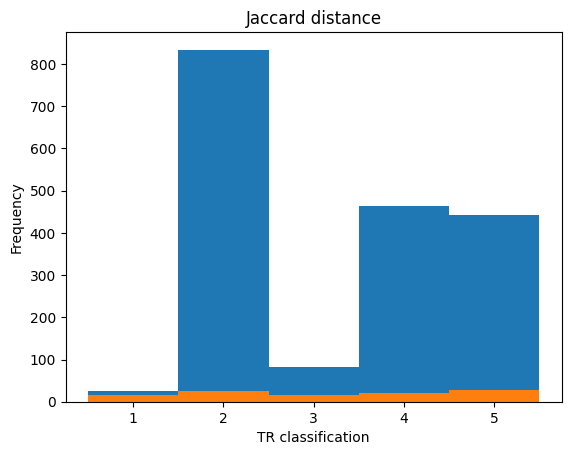

In [ ]:
plt.hist(w,bins=[0.5,1.5,2.5,3.5,4.5,5.5])
plt.hist(w[y>0],bins=[0.5,1.5,2.5,3.5,4.5,5.5])
plt.xticks([1,2,3,4,5])
plt.xlabel('TR classification')
plt.ylabel('Frequency')
plt.title('Jaccard distance')